In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy
import arch
from arch import arch_model

In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

# 1
## a: Historical VaR

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "sp500.csv"), index_col = "Date")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('D')
df["log_return"] = 100 * (np.log(df["Adj Close"]) - np.log(df["Adj Close"]).shift(1))
df.dropna(inplace=True)
df.tail()

,Adj Close,log_return
Date,,
2022-10-21,3752.750000,2.344776
2022-10-24,3797.340088,1.181194
2022-10-25,3859.110107,1.613577
2022-10-26,3830.600098,-0.741514
2022-10-27,3807.300049,-0.610119


The historical VaR is obtained as follows.

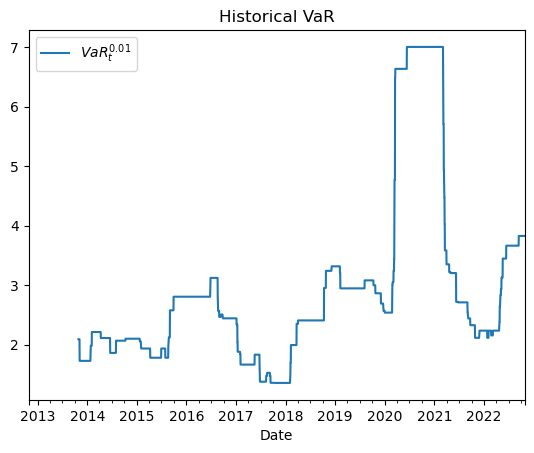

In [4]:
VaR_hist = np.multiply(df["log_return"].rolling(250, closed="left").quantile(0.01), -1)
VaR_hist.plot(label=r"$VaR_t^{0.01}$")
plt.title("Historical VaR")
plt.legend();

## b: Normal VaR
The mean return and volatility are

In [5]:
mu = df["log_return"].mean()
sigma = df["log_return"].std()
print(mu, sigma)

0.03938126491226671 1.1008560474907398


The normal VaR can then be computed as $-\mu-\sigma\cdot\Phi^{-1}_{0.01}=-0.0394 -1.1009 \cdot (-2.326)=2.52$%, where the value of $\Phi^{-1}(0.01)$ can be read of the table for the $t$ distribution (the last row). Note that the table lists the quantiles with the sign reversed; 2.326 is the 99th percentile, while we need the 1st percentile, -2.326. This is a computation that I would expect you to be able to do in an exam. Outside of an exam, we can use Python for our computation:

In [6]:
-mu - sigma * scipy.stats.norm.ppf(0.01)

2.5215928607928184

We can make things a bit more realistic by estimating $\mu$ and $\sigma$ from a rolling window, like for the historical VaR.

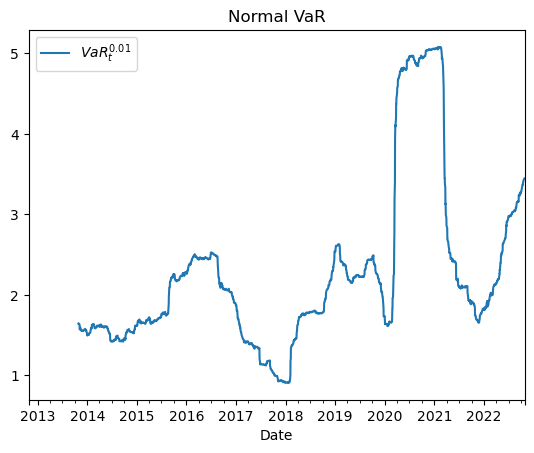

In [7]:
mu = df["log_return"].rolling(250, closed="left").mean()
sigma = df["log_return"].rolling(250, closed="left").std()
VaR_norm = -mu - sigma * scipy.stats.norm.ppf(0.01)
VaR_norm.plot(label=r"$VaR_t^{0.01}$")
plt.title("Normal VaR")
plt.legend();

# 1
## c: GARCH VaR with normal errors
We begin by estimating the model.

In [8]:
model1 = arch_model(df["log_return"], mean='Constant', vol='GARCH', p=1, q=1).fit(disp=None)
print(model1.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3119.24
Distribution:                  Normal   AIC:                           6246.48
Method:            Maximum Likelihood   BIC:                           6269.80
                                        No. Observations:                 2517
Date:                Tue, Oct 10 2023   Df Residuals:                     2516
Time:                        18:07:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0803  1.410e-02      5.697  1.219e-08 [5.269e-0

We then construct in-sample VaR forecasts as 
$$ VaR_{t+1}^{p}=-\mu_{t+1}-\sigma _{t+1}\Phi _{p}^{-1}.$$
$\mu_t$ is just the intercept in the mean equation, 0.0803.

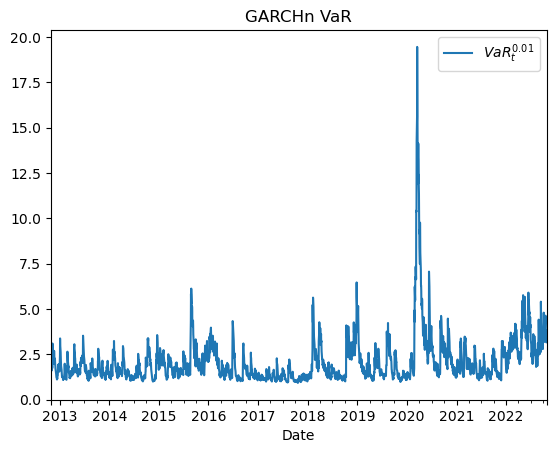

In [9]:
VaR_GARCHn = -0.0803 - model1.conditional_volatility * scipy.stats.norm.ppf(0.01)
VaR_GARCHn.plot(label=r"$VaR_t^{0.01}$");
plt.title("GARCHn VaR")
plt.legend();

Note: The `arch` package also allows for more complicated mean specifications; we could, for example, use an ARMA(1, 1) model. In that case, the mean $\mu_t$ will change over time, and we cannot just read it off from the output. `arch` does not appear to offer a simple way to obtain in-sample mean forecasts. However, we can exploit the relationship $$r_t = \mu_t + u_t\Leftrightarrow \mu_t = r_t - u_t$$ and construct $\mu_t$ as
```Python
mu_t = df["log_return"] - model.resid
```
For our simple model this trick isn´t needed.

In practice, one usually  wouldn´t use in-sample forecasting anyway. Instead, one would backtest the model using a rolling window; see further below.

# 1
## d: GARCH VaR with standardized $t$ errors
The GARCH(1, 1) with Stundent's $t$ errors can be estimated as follows:

In [10]:
model2 = arch_model(df["log_return"], mean='Constant', vol='GARCH', dist= "StudentsT", p=1, q=1).fit(disp=None)
print(model2.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3036.13
Distribution:      Standardized Student's t   AIC:                           6082.26
Method:                  Maximum Likelihood   BIC:                           6111.41
                                              No. Observations:                 2517
Date:                      Tue, Oct 10 2023   Df Residuals:                     2516
Time:                              18:07:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

The estimated degrees of freedom are 5.47, so the data have heavier tails then the normal distribution would imply. The in-sample VaR can be computed as
$$VaR_{t+1}^{p}=-\mu_{t+1}-\sigma _{t+1}\tilde{t}_{p}^{-1}(d)=-\mu_{t+1} - \sigma _{t+1}\sqrt{\frac{%
d-2}{d}}t_{p}^{-1}(d):$$

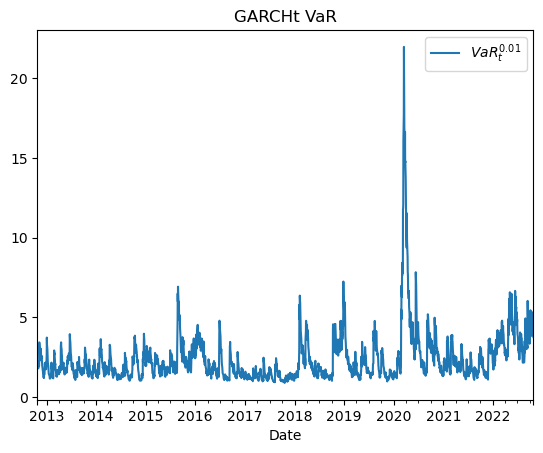

In [11]:
VaR_GARCHt = -0.0913 - model2.conditional_volatility * np.sqrt((5.4748-2)/5.4748) * scipy.stats.t.ppf(0.01, 5.4748)
VaR_GARCHt.plot(label=r"$VaR_t^{0.01}$");
plt.title("GARCHt VaR")
plt.legend();

# 1
## e: Out of sample forecasting
Now, we want to produce an out-of-sample forecast. This means that the forecast period is different from the period used for fitting the model. It is actually quite simple:

In [12]:
forecast = model2.forecast()
mu = forecast.mean
sigma = np.sqrt(forecast.variance)
- mu - sigma * np.sqrt((5.4748-2)/5.4748) * scipy.stats.t.ppf(0.01, 5.4748)

,h.1
Date,
2022-10-27,3.431872


Alternatively, we can use the distribution object that is attached to the model itself; this already incorporates the standardization, so we don't have to multiply with $\sqrt{(\nu-2)/2}$:

In [13]:
- mu - sigma * model2.model.distribution.ppf(0.01, 5.4748)

,h.1
Date,
2022-10-27,3.431872


**Note**: In an exam, I would expect you to do this calculation: I would provide the values for $\mu_{t+1}$, $\sigma_{t+1}$, and $\nu$, and you would have to plug into the formula above. I'd choose an integer for $\nu$, so that you can obtain the relevant quantile from a distribution table.

Now that we know how to produce out-of-sample forecasts, we can actually do a proper backtest, even though the question didn't ask for one. The idea is to have a rolling window of (say) 1000 observations. Starting with the first 1000, we use these to fit a model, and then predict the VaR for period 1001 out of sample. We then move our window forward by one period and repeat, until we arrive at the end of the sample. This is similar to how we used the `rolling` object for the historical VaR.


In [14]:
T = len(df["log_return"])
window = 1000
VaR_GARCHt_OOS = pd.Series(index=df.index, dtype=np.float64)
for t in range(window, T):    
    r = df["log_return"].iloc[t - window : t]
    model = arch_model(r, mean='Constant', vol='GARCH', dist= "StudentsT", p=1, q=1).fit(disp=None)
    fore = model.forecast()
    mu = fore.mean.to_numpy()[0][0]
    sigma = np.sqrt(fore.variance).to_numpy()[0][0]    
    VaR_GARCHt_OOS.iloc[t] = - mu - sigma * model.model.distribution.ppf(0.01, model.params[-1])  # model.params[-1] is the d.o.f.    
    

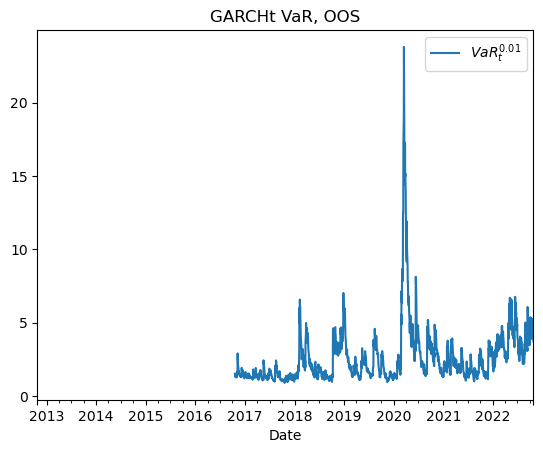

In [15]:
VaR_GARCHt_OOS.plot(label=r"$VaR_t^{0.01}$")
plt.title("GARCHt VaR, OOS")
plt.legend();

# 1
## f: Plotting

We leave out `VaR_GARCHt_OOS`, as it is too similar to the in-sample forecasts.

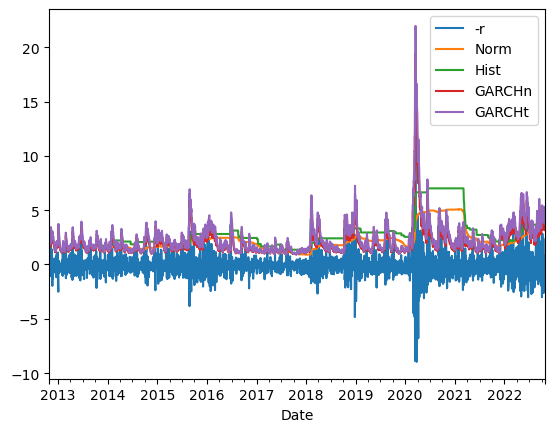

In [16]:
ax = np.multiply(df["log_return"], -1).plot(label="-r")  # negative log returns
VaRs = pd.concat([VaR_norm, VaR_hist, VaR_GARCHn, VaR_GARCHt], axis=1, keys = ["Norm", "Hist", "GARCHn", "GARCHt"])
VaRs.plot(ax=ax)
plt.legend()
#plt.savefig("VaRs.pdf")

# 1
## e: Coverage tests
We start by backtesting the historical VaR. The first step is creating the hit sequence and adding it to our dataframe for the test regressions.

In [17]:
VaRs["I"] = (VaRs["Hist"] < - df["log_return"]).astype(int)
pi = VaRs["I"].mean()
pi

0.0166865315852205

This shows that the empirical unconditional coverage is 1.6% instead of the desired 1%. To test whether this difference is significant, we compute the $t$-statistic
$$\frac{\hat{\pi}-p}{\sqrt{\hat{\pi}(1-\hat{\pi})/T}}$$

In [18]:
t = (pi - 0.01) / np.sqrt(pi * (1-pi) / T)
t

2.6188672033097493

This is larger than the critical value 1.96, so we reject the null of correct unconditional coverage. Alternatively, we could have regressed $I - 0.01$ on an intercept and tested this intercept for significance:

In [19]:
print(smf.ols(formula = "np.subtract(I, 0.01) ~ 1", data=VaRs).fit().summary())

                             OLS Regression Results                             
Dep. Variable:     np.subtract(I, 0.01)   R-squared:                      -0.000
Model:                              OLS   Adj. R-squared:                 -0.000
Method:                   Least Squares   F-statistic:                       nan
Date:                  Tue, 10 Oct 2023   Prob (F-statistic):                nan
Time:                          18:08:18   Log-Likelihood:                 1600.9
No. Observations:                  2517   AIC:                            -3200.
Df Residuals:                      2516   BIC:                            -3194.
Df Model:                             0                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0067      0.003

Clearly, the $t$-statistic is essentially the same, so we reach the same conclusion.

If we want to test conditional coverage as well, we have to include a lag of $I$ in the regression. We also have to explicitly add an intercept `b0` to the dataframe, because we want to jointly best $b_0 = b_1 = 0$, and this is not possible with the intercept that `statsmodels` would include automatically (but which we suppress with the `0` in the formula below). Note that the standard $F$-test reported in the output tests all variable *except* the intercept, but here we want to test the intercept as well.

In [20]:
VaRs["b0"] = 1
res = smf.ols(formula = "np.subtract(I, 0.01) ~ 0 + b0 + I.shift(1) ", data=VaRs).fit()
print(res.summary())
VaRs.drop(["I", "b0"], axis=1, inplace=True)  # clean up 

                             OLS Regression Results                             
Dep. Variable:     np.subtract(I, 0.01)   R-squared:                       0.011
Model:                              OLS   Adj. R-squared:                  0.010
Method:                   Least Squares   F-statistic:                     27.54
Date:                  Tue, 10 Oct 2023   Prob (F-statistic):           1.67e-07
Time:                          18:08:18   Log-Likelihood:                 1613.5
No. Observations:                  2516   AIC:                            -3223.
Df Residuals:                      2514   BIC:                            -3211.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
b0             0.0050      0.003

We can now test for unconditional coverage using `b0`, and for independence using `I.shift(1)`. The former no longer rejects at the 5% level (although barely), while the latter does. The $F$-test for conditional coverage tests the two jointly. It is obtained as follows.

In [21]:
F = res.f_test(["b0 = 0", "I.shift(1) = 0"])
F.summary()

'<F test: F=17.23716843564351, p=3.671605361242782e-08, df_denom=2.51e+03, df_num=2>'

The $F$-test clearly rejects the null of correct conditional coverage with a $p$-value of $3.67\cdot 10^{-8}.$

We repeat the procedure for our other VaR estimates.

In [22]:
backtests = pd.DataFrame(columns = ["pi", "t", "b0", "t_b0", "b1", "t_b1", "F"])
for name in VaRs.columns:    
    VaRs["b0"] = 1
    VaRs["I"] = (VaRs[name] < - df["log_return"]).astype(int)
    pi = VaRs["I"].mean()
    t = (pi - 0.01) / np.sqrt(pi * (1-pi) / T)
    res = smf.ols(formula = "np.subtract(I, 0.01) ~ 0 + b0 + I.shift(1) ", data=VaRs).fit()    
    b0 = res.params["b0"]
    b1 = res.params["I.shift(1)"]
    t_b0 = res.tvalues["b0"]
    t_b1 = res.tvalues["I.shift(1)"]
    F = res.f_test(["b0 = 0", "I.shift(1) = 0"]).fvalue
    backtests.loc[name] = [pi, t, b0, t_b0, b1, t_b1, F]
VaRs.drop(["I", "b0"], axis=1, inplace=True)    
print(backtests.T)


           Norm       Hist     GARCHn    GARCHt
pi     0.030989   0.016687   0.025427  0.017084
t      6.076717   2.618867   4.916661  2.742577
b0     0.018712   0.004956   0.015285  0.006579
t_b0   5.343180   1.933614   4.805458  2.524421
b1     0.073852   0.104092   0.005965  0.029933
t_b1   3.713067   5.247664   0.299065  1.501486
F     25.450432  17.237168  12.128665  4.892722


The critical value for the $F$-test is 3.0, so correct conditional coverage is rejected for all models. The GARCH-$t$ models fares best, though